In [1]:
# load in the correct modules
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import tqdm
import cmasher as cm
from matplotlib import rc
# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)
import warnings
warnings.filterwarnings('ignore')
import jax
from scipy import stats
import matplotlib.gridspec as grid
from matplotlib.colors import LogNorm

In [2]:
import h5py
f = h5py.File("/Users/dhortadarrington/Documents/Projects/mw-bar/data/AllClassifications_APOGEE_all_feh8_SNRc.h5","r")
# f.keys() # this would list all the APOGEE IDs, including doubles for half-integer bins
median_knot_probability = []
median_bar_probability = []
median_disc_probability = []
std_knot_probability = []
std_bar_probability = []
std_disc_probability = []
all_knot_probability = []
all_bar_probability = []
all_disc_probability = []
RxyzL = []


for key in tqdm.tqdm_notebook(f.keys()):
    median_knot_probability.append(np.nanmedian(f[key][:,2]))
    median_bar_probability.append(np.nanmedian(f[key][:,1]))
    median_disc_probability.append(np.nanmedian(f[key][:,0]))
    std_knot_probability.append(np.nanstd(f[key][:,2]))
    std_bar_probability.append(np.nanstd(f[key][:,1]))
    std_disc_probability.append(np.nanstd(f[key][:,0]))
    all_knot_probability.append((f[key][:,2]))
    all_bar_probability.append((f[key][:,1]))
    all_disc_probability.append((f[key][:,0]))
    RxyzL.append(f[key][:,3][:7])
f.close() # don't forget to close the file!


  0%|          | 0/32489 [00:00<?, ?it/s]

In [3]:
RxyzL_ = np.array(RxyzL)
R = RxyzL_[:,0]
x = RxyzL_[:,1]
y = RxyzL_[:,2]
z = RxyzL_[:,3]
Lx = RxyzL_[:,4]
Ly = RxyzL_[:,5]
Lz = RxyzL_[:,6]


In [4]:
import pandas as pd

dat = pd.read_csv('/Users/dhortadarrington/Documents/Projects/mw-bar/data/knotbardisc-Gaussianfits.csv')


In [292]:
dat['alpha'][dat['comp']=='bar']

1     38.8
4     35.4
7     40.1
10    58.5
13    75.8
17    80.7
20    78.9
Name: alpha, dtype: float64

In [295]:
dat['alpha'][dat['comp']=='disc']

0     24.2
3     31.6
6     44.7
9     52.8
12    67.1
16    78.6
18    84.7
23    82.6
26    83.9
Name: alpha, dtype: float64

# Make the 2D model vs data plot for all radius bins

In [358]:
def multivariate_gaussian_angle(pos, mu, Sigma, angle):
    """Return the multivariate Gaussian distribution on array pos."""
    
    n = mu.shape[0]
    angle_rad = np.deg2rad(-angle)
    # rotate counter-clockwise
    rot_mat = np.array(([np.cos(angle_rad), -np.sin(angle_rad)],[np.sin(angle_rad), np.cos(angle_rad)]))
    Sigma_det = np.linalg.det(Sigma)
    Sigma_inv = np.linalg.inv(Sigma)
    N = np.sqrt((2*np.pi)**n * Sigma_det)
    # This einsum call calculates (x-mu)T.Sigma-1.(x-mu) in a vectorized
    # way across all the input variables.
    # here '.' must be dummy dimensions
    fac = np.einsum('...k,kl,...l->...', (pos-mu)@rot_mat, Sigma_inv, (pos-mu)@rot_mat)
    
    return np.exp(-fac / 2) / N

def multivariate_gaussian(pos, mu, Sigma):
    """Return the multivariate Gaussian distribution on array pos."""
    
    n = mu.shape[0]
    Sigma_det = np.linalg.det(Sigma)
    Sigma_inv = np.linalg.inv(Sigma)
    N = np.sqrt((2*np.pi)**n * Sigma_det)
    # This einsum call calculates (x-mu)T.Sigma-1.(x-mu) in a vectorized
    # way across all the input variables.
    fac = np.einsum('...k,kl,...l->...', pos-mu, Sigma_inv, pos-mu)
    
    return np.exp(-fac / 2) / N


In [359]:
## Our 2-dimensional distribution will be over variables X and Y
N = 91
L1_samples = np.linspace(-800,800,N)
L2_samples = np.linspace(-800,800,N)
L3_samples = np.linspace(-1500,1500,N)

#find bin centers
L1c = (L1_samples[1:]+L1_samples[:-1])/2.
L2c = (L2_samples[1:]+L2_samples[:-1])/2.
L3c = (L3_samples[1:]+L3_samples[:-1])/2.

#make a grid at the bin centers
L1, L2 = np.meshgrid(L1c, L2c) # for Lx-Ly
L1_2, L3 = np.meshgrid(L1c, L3c) # for Lx-Lz
L2_2, L3_2 = np.meshgrid(L2c, L3c) # for Ly-Lz

# Pack X and Y into a single 3-dimensional array
pos_lxly = np.empty(L1.shape + (2,))
pos_lxly[:, :, 0] = L1
pos_lxly[:, :, 1] = L2

pos_lxlz = np.empty(L1_2.shape + (2,))
pos_lxlz[:, :, 0] = L1_2
pos_lxlz[:, :, 1] = L3

pos_lylz = np.empty(L2_2.shape + (2,))
pos_lylz[:, :, 0] = L2_2
pos_lylz[:, :, 1] = L3_2


In [390]:
rad = '0405'
datContent = np.array([i.strip().split() for i in open("/Users/dhortadarrington/Documents/Projects/mw-bar/data/APOGEE_all_feh8_SNRc_d"+str(rad)+".dat").readlines()])
# datContent2 = np.array([i.strip().split() for i in open("/Users/dhortadarrington/Downloads/APOGEE_all_feh6_SNRc_d0304.dat").readlines()])


In [391]:
# 2-3
# 3-4
# 4-5 for these bins alpha needs to be negative (idk why)


In [392]:
err_lx = np.fromiter(datContent[:,3],dtype=float)
err_ly = np.fromiter(datContent[:,4],dtype=float)
err_lz = np.fromiter(datContent[:,5],dtype=float)


In [398]:
def plot_2d_model_data_comp(radmin,radmax,ncomp,err_x, err_y, err_z, name):
    
    fig = plt.figure(figsize=(20,16), facecolor='white', constrained_layout=True)

    mask_rad = (dat['binmin']==radmin)&(dat['binmax']==radmax)
    mknot = dat['comp']=='knot'
    mbar = dat['comp']=='bar'
    mdisc = dat['comp']=='disc'
    facnorm = 1e5

    plt.subplot(3,3,1)
    plt.title('Data ($'+str(radmin)+' < R < '+str(radmax)+'$ [kpc])', fontsize=30)
    hist, xedges,yedges = np.histogram2d(Lx[(R>radmin)&(R<radmax)], Ly[(R>radmin)&(R<radmax)],bins=[L1_samples, L2_samples])
    dx, dy = L1_samples[1]-L1_samples[0], L2_samples[1]-L2_samples[0]
    histnorm = np.sum(hist)*dx*dy
    hist = hist/histnorm
    fac = np.nanmax(hist)
    plt.imshow(np.rot90(hist)/fac, aspect='auto',norm = LogNorm(vmin=0.001,vmax=1), extent=[L1_samples.min(),L1_samples.max(),L2_samples.min(),L2_samples.max()], cmap=cm.lavender)
    plt.xlabel(r'L$_{x}$ [kpc km s$^{-1}$]', fontsize=26)    
    plt.ylabel(r'L$_{y}$ [kpc km s$^{-1}$]', fontsize=26)    
    plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=8)
    plt.tick_params(which='minor', length=4, direction='in',top=True,right=True)
    plt.minorticks_on()
    # plt.text(200,400,r'$1 < R < 2$ [kpc]', fontsize=22)

    plt.subplot(3,3,2)
    plt.title('Model', fontsize=30)
    
    if ncomp==3:
        # component1
        meanL1_comp1 = np.median(dat['Lx'][mask_rad&mknot])
        meanL2_comp1 = np.median(dat['Ly'][mask_rad&mknot])
#         SL1_comp1 = (np.median(dat['Lx+'][mask_rad&mknot] - np.median(dat['Lx-'][mask_rad&mknot])))/2.
#         SL2_comp1 = (np.median(dat['Ly+'][mask_rad&mknot] - np.median(dat['Ly-'][mask_rad&mknot])))/2.
        SL1_comp1 = np.nanmean(err_x)
        SL2_comp1 = np.nanmean(err_y)
        sigmaL1_comp1 = np.sqrt(np.median(dat['sigmax'][mask_rad&mknot])**2+SL1_comp1**2)
        sigmaL2_comp1 = np.sqrt(np.median(dat['sigmay'][mask_rad&mknot])**2+SL2_comp1**2)
        M_comp1 = np.array(([meanL1_comp1, meanL2_comp1]))
        S_comp1 = np.array(([sigmaL1_comp1**2, 0.], [0., sigmaL2_comp1**2]))
        # component 2
        meanL1_comp2 = np.median(dat['Lx'][mask_rad&mbar])
        meanL2_comp2 = np.median(dat['Ly'][mask_rad&mbar])
#         SL1_comp2 = (np.median(dat['Lx+'][mask_rad&mbar] - np.median(dat['Lx-'][mask_rad&mbar])))/2.
#         SL2_comp2 = (np.median(dat['Ly+'][mask_rad&mbar] - np.median(dat['Ly-'][mask_rad&mbar])))/2.
        SL1_comp2 = np.nanmean(err_x)
        SL2_comp2 = np.nanmean(err_y)
        sigmaL1_comp2 = np.sqrt(np.median(dat['sigmax'][mask_rad&mbar])**2+SL1_comp2**2)
        sigmaL2_comp2 = np.sqrt(np.median(dat['sigmay'][mask_rad&mbar])**2+SL2_comp2**2)
        M_comp2 = np.array(([meanL1_comp2, meanL2_comp2]))
        S_comp2 = np.array(([sigmaL1_comp2**2, 0.], [0., sigmaL2_comp2**2]))
        # component 3
        meanL1_comp3 = np.median(dat['Lx'][mask_rad&mdisc])
        meanL2_comp3 = np.median(dat['Ly'][mask_rad&mdisc])
#         SL1_comp3 = (np.median(dat['Lx+'][mask_rad&mdisc] - np.median(dat['Lx-'][mask_rad&mdisc])))/2.
#         SL2_comp3 = (np.median(dat['Ly+'][mask_rad&mdisc] - np.median(dat['Ly-'][mask_rad&mdisc])))/2.
        SL1_comp3 = np.nanmean(err_x)
        SL2_comp3 = np.nanmean(err_y)
        sigmaL1_comp3 = np.sqrt(np.median(dat['sigmax'][mask_rad&mdisc])**2+SL1_comp3**2)
        sigmaL2_comp3 = np.sqrt(np.median(dat['sigmay'][mask_rad&mdisc])**2+SL2_comp3**2)
        M_comp3 = np.array(([meanL1_comp3, meanL2_comp3]))
        S_comp3 = np.array(([sigmaL1_comp3**2, 0.], [0., sigmaL2_comp3**2]))
        # calculate the fractions
        frac_comp1 = np.median(dat['f'][mask_rad&mknot])
        frac_comp2 = np.median(dat['f'][mask_rad&mbar])
        frac_comp3 = np.median(dat['f'][mask_rad&mdisc])
        # get tha angles
        angle_comp1 = np.median(dat['alpha'][mask_rad&mknot])
        angle_comp2 = np.median(dat['alpha'][mask_rad&mbar])
        angle_comp3 = np.median(dat['alpha'][mask_rad&mdisc])
        
        Z_comp1 = multivariate_gaussian_angle(pos_lxly, M_comp1, S_comp1, angle_comp1)
        Z_comp2 = multivariate_gaussian_angle(pos_lxly, M_comp2, S_comp2, angle_comp2)
        Z_comp3 = multivariate_gaussian_angle(pos_lxly, M_comp3, S_comp3, angle_comp3)

        Z_tot = Z_comp1*frac_comp1 + Z_comp2*frac_comp2 + Z_comp3*frac_comp3
    
    elif ncomp==2:
        # component 2
        meanL1_comp2 = np.median(dat['Lx'][mask_rad&mbar])
        meanL2_comp2 = np.median(dat['Ly'][mask_rad&mbar])
        SL1_comp2 = np.nanmean(err_x)
        SL2_comp2 = np.nanmean(err_y)
#         SL1_comp2 = (np.median(dat['Lx+'][mask_rad&mbar] - np.median(dat['Lx-'][mask_rad&mbar])/2.))
#         SL2_comp2 = (np.median(dat['Ly+'][mask_rad&mbar] - np.median(dat['Ly-'][mask_rad&mbar])/2.))
        sigmaL1_comp2 = np.sqrt(np.median(dat['sigmax'][mask_rad&mbar])**2+SL1_comp2**2)
        sigmaL2_comp2 = np.sqrt(np.median(dat['sigmay'][mask_rad&mbar])**2+SL2_comp2**2)
        M_comp2 = np.array(([meanL1_comp2, meanL2_comp2]))
        S_comp2 = np.array(([sigmaL1_comp2**2, 0.], [0., sigmaL2_comp2**2]))
        # component 3
        meanL1_comp3 = np.median(dat['Lx'][mask_rad&mdisc])
        meanL2_comp3 = np.median(dat['Ly'][mask_rad&mdisc])
#         SL1_comp3 = (np.median(dat['Lx+'][mask_rad&mdisc] - np.median(dat['Lx-'][mask_rad&mdisc])/2.))
#         SL2_comp3 = (np.median(dat['Ly+'][mask_rad&mdisc] - np.median(dat['Ly-'][mask_rad&mdisc])/2.))
        SL1_comp3 = np.nanmean(err_x)
        SL2_comp3 = np.nanmean(err_y)
        sigmaL1_comp3 = np.sqrt(np.median(dat['sigmax'][mask_rad&mdisc])**2+SL1_comp3**2)
        sigmaL2_comp3 = np.sqrt(np.median(dat['sigmay'][mask_rad&mdisc])**2+SL2_comp3**2)
        M_comp3 = np.array(([meanL1_comp3, meanL2_comp3]))
        S_comp3 = np.array(([sigmaL1_comp3**2, 0.], [0., sigmaL2_comp3**2]))
        # calculate the fractions
        frac_comp2 = np.median(dat['f'][mask_rad&mbar])
        frac_comp3 = np.median(dat['f'][mask_rad&mdisc])
        # get tha angles
        angle_comp2 = np.median(dat['alpha'][mask_rad&mbar])
        angle_comp3 = np.median(dat['alpha'][mask_rad&mdisc])

        Z_comp2 = multivariate_gaussian_angle(pos_lxly, M_comp2, S_comp2, angle_comp2)
        Z_comp3 = multivariate_gaussian_angle(pos_lxly, M_comp3, S_comp3, angle_comp3)
                
        Z_tot = Z_comp2*frac_comp2 + Z_comp3*frac_comp3
        
    elif ncomp==1:
        # component 3
        meanL1_comp3 = np.median(dat['Lx'][mask_rad&mdisc])
        meanL2_comp3 = np.median(dat['Ly'][mask_rad&mdisc])
        SL1_comp3 = np.nanmean(err_x)
        SL2_comp3 = np.nanmean(err_y)
#         SL1_comp3 = (np.median(dat['Lx+'][mask_rad&mdisc] - np.median(dat['Lx-'][mask_rad&mdisc])/2.))
#         SL2_comp3 = (np.median(dat['Ly+'][mask_rad&mdisc] - np.median(dat['Ly-'][mask_rad&mdisc])/2.))
        sigmaL1_comp3 = np.sqrt(np.median(dat['sigmax'][mask_rad&mdisc])**2+SL1_comp3**2)
        sigmaL2_comp3 = np.sqrt(np.median(dat['sigmay'][mask_rad&mdisc])**2+SL2_comp3**2)
        M_comp3 = np.array(([meanL1_comp3, meanL2_comp3]))
        S_comp3 = np.array(([sigmaL1_comp3**2, 0.], [0., sigmaL2_comp3**2]))
        # calculate the fractions
        frac_comp3 = np.median(dat['f'][mask_rad&mdisc])
        # get tha angles
        angle_comp3 = np.median(dat['alpha'][mask_rad&mdisc])
        Z_comp3 = multivariate_gaussian_angle(pos_lxly, M_comp3, S_comp3, angle_comp3)
        Z_tot = Z_comp3*frac_comp3        
        
    # plot
    plt.imshow(Z_tot/fac, aspect='auto',norm = LogNorm(vmin=0.001,vmax=1), extent=[L1_samples.min(),L1_samples.max(),L2_samples.min(),L2_samples.max()], cmap=cm.lavender)
    plt.xlabel(r'L$_{x}$ [kpc km s$^{-1}$]', fontsize=26)    
    plt.ylabel(r'L$_{y}$ [kpc km s$^{-1}$]', fontsize=26)    
    plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=8)
    plt.tick_params(which='minor', length=4, direction='in',top=True,right=True)
    plt.minorticks_on()

    plt.subplot(3,3,3)
    plt.title('(Data - Model)', fontsize=30)
    resid = (np.rot90(hist)-Z_tot)
    plt.imshow(resid/fac, aspect='auto',extent=[L1_samples.min(),L1_samples.max(),L2_samples.min(),L2_samples.max()],cmap=cm.prinsenvlag_r,vmin=-0.4,vmax=0.4)
    # plt.colorbar()
    plt.xlabel(r'L$_{x}$ [kpc km s$^{-1}$]', fontsize=26)    
    plt.ylabel(r'L$_{y}$ [kpc km s$^{-1}$]', fontsize=26)    
    plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=8)
    plt.tick_params(which='minor', length=4, direction='in',top=True,right=True)
    plt.minorticks_on()

    plt.subplot(3,3,4)
    # plt.title('Data', fontsize=30)
    hist2, xedges,yedges = np.histogram2d(Lx[(R>radmin)&(R<radmax)], -Lz[(R>radmin)&(R<radmax)],bins=[L1_samples, L3_samples])
    dx, dy = L1_samples[1]-L1_samples[0], L3_samples[1]-L3_samples[0]
    histnorm2 = np.sum(hist2)*dx*dy
    hist2 = hist2/histnorm2
    fac2 = np.nanmax(hist2)
    plt.imshow(np.rot90(hist2)/fac2, aspect='auto',norm = LogNorm(vmin=0.001,vmax=1), extent=[L1_samples.min(),L1_samples.max(),L3_samples.min(),L3_samples.max()], cmap=cm.lavender)
    plt.xlabel(r'L$_{x}$ [kpc km s$^{-1}$]', fontsize=26)    
    plt.ylabel(r'L$_{z}$ [kpc km s$^{-1}$]', fontsize=26)    
    plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=8)
    plt.tick_params(which='minor', length=4, direction='in',top=True,right=True)
    plt.minorticks_on()

    plt.subplot(3,3,5)
    if ncomp==3:
        # component1
        meanL1_comp1 = np.median(dat['Lx'][mask_rad&mknot])
        meanL2_comp1 = np.median(-dat['Lz'][mask_rad&mknot])
#         SL1_comp1 = (np.median(dat['Lx+'][mask_rad&mknot] - np.median(dat['Lx-'][mask_rad&mknot])/2.))
#         SL2_comp1 = (np.median(dat['Lz+'][mask_rad&mknot] - np.median(dat['Lz-'][mask_rad&mknot])/2.))
        SL1_comp1 = np.nanmean(err_x)
        SL2_comp1 = np.nanmean(err_z)
        sigmaL1_comp1 = np.sqrt(np.median(dat['sigmax'][mask_rad&mknot])**2+SL1_comp1**2)
        sigmaL2_comp1 = np.sqrt(np.median(dat['sigmaz'][mask_rad&mknot])**2+SL2_comp1**2)
        M_comp1 = np.array(([meanL1_comp1, meanL2_comp1]))
        S_comp1 = np.array(([sigmaL1_comp1**2, 0.], [0., sigmaL2_comp1**2]))
        # component 2
        meanL1_comp2 = np.median(dat['Lx'][mask_rad&mbar])
        meanL2_comp2 = np.median(-dat['Lz'][mask_rad&mbar])
        SL1_comp2 = np.nanmean(err_x)
        SL2_comp2 = np.nanmean(err_z)
#         SL1_comp2 = (np.median(dat['Lx+'][mask_rad&mbar] - np.median(dat['Lx-'][mask_rad&mbar])/2.))
#         SL2_comp2 = (np.median(dat['Lz+'][mask_rad&mbar] - np.median(dat['Lz-'][mask_rad&mbar])/2.))
        sigmaL1_comp2 = np.sqrt(np.median(dat['sigmax'][mask_rad&mbar])**2+SL1_comp2**2)
        sigmaL2_comp2 = np.sqrt(np.median(dat['sigmaz'][mask_rad&mbar])**2+SL2_comp2**2)
        M_comp2 = np.array(([meanL1_comp2, meanL2_comp2]))
        S_comp2 = np.array(([sigmaL1_comp2**2, 0.], [0., sigmaL2_comp2**2]))
        # component 3
        meanL1_comp3 = np.median(dat['Lx'][mask_rad&mdisc])
        meanL2_comp3 = np.median(-dat['Lz'][mask_rad&mdisc])
        SL1_comp3 = np.nanmean(err_x)
        SL2_comp3 = np.nanmean(err_z)
#         SL1_comp3 = (np.median(dat['Lx+'][mask_rad&mdisc] - np.median(dat['Lx-'][mask_rad&mdisc])/2.))
#         SL2_comp3 = (np.median(dat['Lz+'][mask_rad&mdisc] - np.median(dat['Lz-'][mask_rad&mdisc])/2.))
        sigmaL1_comp3 = np.sqrt(np.median(dat['sigmax'][mask_rad&mdisc])**2+SL1_comp3**2)
        sigmaL2_comp3 = np.sqrt(np.median(dat['sigmaz'][mask_rad&mdisc])**2+SL2_comp3**2)
        M_comp3 = np.array(([meanL1_comp3, meanL2_comp3]))
        S_comp3 = np.array(([sigmaL1_comp3**2, 0.], [0., sigmaL2_comp3**2]))
        # calculate the fractions
        frac_comp1 = np.median(dat['f'][mask_rad&mknot])
        frac_comp2 = np.median(dat['f'][mask_rad&mbar])
        frac_comp3 = np.median(dat['f'][mask_rad&mdisc])
        
        Z_comp1 = multivariate_gaussian(pos_lxlz, M_comp1, S_comp1)
        Z_comp2 = multivariate_gaussian(pos_lxlz, M_comp2, S_comp2)
        Z_comp3 = multivariate_gaussian(pos_lxlz, M_comp3, S_comp3)

        Z_tot2 = Z_comp1*frac_comp1 + Z_comp2*frac_comp2 + Z_comp3*frac_comp3
    
    elif ncomp==2:
        # component 2
        meanL1_comp2 = np.median(dat['Lx'][mask_rad&mbar])
        meanL2_comp2 = np.median(-dat['Lz'][mask_rad&mbar])
#         SL1_comp2 = (np.median(dat['Lx+'][mask_rad&mbar] - np.median(dat['Lx-'][mask_rad&mbar])/2.))
#         SL2_comp2 = (np.median(dat['Lz+'][mask_rad&mbar] - np.median(dat['Lz-'][mask_rad&mbar])/2.))
        SL1_comp2 = np.nanmean(err_x)
        SL2_comp2 = np.nanmean(err_z)
        sigmaL1_comp2 = np.sqrt(np.median(dat['sigmax'][mask_rad&mbar])**2+SL1_comp2**2)
        sigmaL2_comp2 = np.sqrt(np.median(dat['sigmaz'][mask_rad&mbar])**2+SL2_comp2**2)
        M_comp2 = np.array(([meanL1_comp2, meanL2_comp2]))
        S_comp2 = np.array(([sigmaL1_comp2**2, 0.], [0., sigmaL2_comp2**2]))
        # component 3
        meanL1_comp3 = np.median(dat['Lx'][mask_rad&mdisc])
        meanL2_comp3 = np.median(-dat['Lz'][mask_rad&mdisc])
        SL1_comp3 = np.nanmean(err_x)
        SL2_comp3 = np.nanmean(err_z)
#         SL1_comp3 = (np.median(dat['Lx+'][mask_rad&mdisc] - np.median(dat['Lx-'][mask_rad&mdisc])/2.))
#         SL2_comp3 = (np.median(dat['Lz+'][mask_rad&mdisc] - np.median(dat['Lz-'][mask_rad&mdisc])/2.))
        sigmaL1_comp3 = np.sqrt(np.median(dat['sigmax'][mask_rad&mdisc])**2+SL1_comp3**2)
        sigmaL2_comp3 = np.sqrt(np.median(dat['sigmaz'][mask_rad&mdisc])**2+SL2_comp3**2)
        M_comp3 = np.array(([meanL1_comp3, meanL2_comp3]))
        S_comp3 = np.array(([sigmaL1_comp3**2, 0.], [0., sigmaL2_comp3**2]))
        # calculate the fractions
        frac_comp2 = np.median(dat['f'][mask_rad&mbar])
        frac_comp3 = np.median(dat['f'][mask_rad&mdisc])
        
        Z_comp2 = multivariate_gaussian(pos_lxlz, M_comp2, S_comp2)
        Z_comp3 = multivariate_gaussian(pos_lxlz, M_comp3, S_comp3)  
        
        Z_tot2 = Z_comp2*frac_comp2 + Z_comp3*frac_comp3
        
    elif ncomp==1:
        # component 3
        meanL1_comp3 = np.median(dat['Lx'][mask_rad&mdisc])
        meanL2_comp3 = np.median(dat['Lz'][mask_rad&mdisc])
        SL1_comp3 = np.nanmean(err_x)
        SL2_comp3 = np.nanmean(err_z)
#         SL1_comp3 = (np.median(dat['Lx+'][mask_rad&mdisc] - np.median(dat['Lx-'][mask_rad&mdisc])/2.))
#         SL2_comp3 = (np.median(dat['Lz+'][mask_rad&mdisc] - np.median(dat['Lz-'][mask_rad&mdisc])/2.))
        sigmaL1_comp3 = np.sqrt(np.median(dat['sigmax'][mask_rad&mdisc])**2+SL1_comp3**2)
        sigmaL2_comp3 = np.sqrt(np.median(dat['sigmaz'][mask_rad&mdisc])**2+SL2_comp3**2)
        M_comp3 = np.array(([meanL1_comp3, meanL2_comp3]))
        S_comp3 = np.array(([sigmaL1_comp3**2, 0.], [0., sigmaL2_comp3**2]))
        # calculate the fractions
        frac_comp3 = np.median(dat['f'][mask_rad&mdisc])

        Z_comp3 = multivariate_gaussian(pos_lxlz, M_comp3, S_comp3)
        Z_tot2 = Z_comp3*frac_comp3    
        
    # plot
#     plt.imshow(np.rot90(np.rot90(Z_tot2))/fac2, aspect='auto',norm = LogNorm(vmin=0.001,vmax=1), extent=[L1_samples.min(),L1_samples.max(),L3_samples.min(),L3_samples.max()], cmap=cm.lavender)
    plt.imshow(Z_tot2/fac2, aspect='auto',norm = LogNorm(vmin=0.001,vmax=1), extent=[L1_samples.min(),L1_samples.max(),L3_samples.min(),L3_samples.max()], cmap=cm.lavender)
    plt.xlabel(r'L$_{x}$ [kpc km s$^{-1}$]', fontsize=26)    
    plt.ylabel(r'L$_{z}$ [kpc km s$^{-1}$]', fontsize=26)    
    plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=8)
    plt.tick_params(which='minor', length=4, direction='in',top=True,right=True)
    plt.minorticks_on()

    plt.subplot(3,3,6)
    # plt.title('Residuals', fontsize=30)
#     resid2 = (np.rot90(hist2)-np.rot90(np.rot90(Z_tot2)))#/Z_tot2
    resid2 = (np.rot90(hist2)-Z_tot2)#/Z_tot2
    plt.imshow(resid2/fac2, aspect='auto',extent=[L1_samples.min(),L1_samples.max(),L3_samples.min(),L3_samples.max()],cmap=cm.prinsenvlag_r,vmin=-0.4,vmax=0.4)
    # plt.colorbar()
    plt.xlabel(r'L$_{x}$ [kpc km s$^{-1}$]', fontsize=26)    
    plt.ylabel(r'L$_{z}$ [kpc km s$^{-1}$]', fontsize=26)    
    plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=8)
    plt.tick_params(which='minor', length=4, direction='in',top=True,right=True)
    plt.minorticks_on()

    plt.subplot(3,3,7)
    # plt.title('Data', fontsize=30)
    hist3, xedges,yedges = np.histogram2d(Ly[(R>radmin)&(R<radmax)], -Lz[(R>radmin)&(R<radmax)],bins=[L2_samples, L3_samples])
    dx, dy = L2_samples[1]-L2_samples[0], L3_samples[1]-L3_samples[0]
    histnorm3 = np.sum(hist3)*dx*dy
    hist3 = hist3/histnorm3
    fac3 = np.nanmax(hist3)
    plt.imshow(np.rot90(hist3)/fac3, aspect='auto',norm = LogNorm(vmin=0.001,vmax=1), extent=[L2_samples.min(),L2_samples.max(),L3_samples.min(),L3_samples.max()], cmap=cm.lavender)
    plt.xlabel(r'L$_{y}$ [kpc km s$^{-1}$]', fontsize=26)    
    plt.ylabel(r'L$_{z}$ [kpc km s$^{-1}$]', fontsize=26)    
    plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=8)
    plt.tick_params(which='minor', length=4, direction='in',top=True,right=True)
    plt.minorticks_on()

    plt.subplot(3,3,8)
    if ncomp==3:
        # component1
        meanL1_comp1 = np.median(dat['Ly'][mask_rad&mknot])
        meanL2_comp1 = np.median(-dat['Lz'][mask_rad&mknot])
        SL1_comp1 = np.nanmean(err_y)
        SL2_comp1 = np.nanmean(err_z)
#         SL1_comp1 = (np.median(dat['Ly+'][mask_rad&mknot] - np.median(dat['Ly-'][mask_rad&mknot])/2.))
#         SL2_comp1 = (np.median(dat['Lz+'][mask_rad&mknot] - np.median(dat['Lz-'][mask_rad&mknot])/2.))
        sigmaL1_comp1 = np.sqrt(np.median(dat['sigmay'][mask_rad&mknot])**2+SL1_comp1**2)
        sigmaL2_comp1 = np.sqrt(np.median(dat['sigmaz'][mask_rad&mknot])**2+SL2_comp1**2)
        M_comp1 = np.array(([meanL1_comp1, meanL2_comp1]))
        S_comp1 = np.array(([sigmaL1_comp1**2, 0.], [0., sigmaL2_comp1**2]))
        # component 2
        meanL1_comp2 = np.median(dat['Ly'][mask_rad&mbar])
        meanL2_comp2 = np.median(-dat['Lz'][mask_rad&mbar])
#         SL1_comp2 = (np.median(dat['Ly+'][mask_rad&mbar] - np.median(dat['Ly-'][mask_rad&mbar])/2.))
#         SL2_comp2 = (np.median(dat['Lz+'][mask_rad&mbar] - np.median(dat['Lz-'][mask_rad&mbar])/2.))
        SL1_comp2 = np.nanmean(err_y)
        SL2_comp2 = np.nanmean(err_z)
        sigmaL1_comp2 = np.sqrt(np.median(dat['sigmay'][mask_rad&mbar])**2+SL1_comp2**2)
        sigmaL2_comp2 = np.sqrt(np.median(dat['sigmaz'][mask_rad&mbar])**2+SL2_comp2**2)
        M_comp2 = np.array(([meanL1_comp2, meanL2_comp2]))
        S_comp2 = np.array(([sigmaL1_comp2**2, 0.], [0., sigmaL2_comp2**2]))
        # component 3
        meanL1_comp3 = np.median(dat['Ly'][mask_rad&mdisc])
        meanL2_comp3 = np.median(-dat['Lz'][mask_rad&mdisc])
        SL1_comp3 = np.nanmean(err_y)
        SL2_comp3 = np.nanmean(err_z)
#         SL1_comp3 = (np.median(dat['Ly+'][mask_rad&mdisc] - np.median(dat['Ly-'][mask_rad&mdisc])/2.))
#         SL2_comp3 = (np.median(dat['Lz+'][mask_rad&mdisc] - np.median(dat['Lz-'][mask_rad&mdisc])/2.))
        sigmaL1_comp3 = np.sqrt(np.median(dat['sigmay'][mask_rad&mdisc])**2+SL1_comp3**2)
        sigmaL2_comp3 = np.sqrt(np.median(dat['sigmaz'][mask_rad&mdisc])**2+SL2_comp3**2)
        M_comp3 = np.array(([meanL1_comp3, meanL2_comp3]))
        S_comp3 = np.array(([sigmaL1_comp3**2, 0.], [0., sigmaL2_comp3**2]))
        # calculate the fractions
        frac_comp1 = np.median(dat['f'][mask_rad&mknot])
        frac_comp2 = np.median(dat['f'][mask_rad&mbar])
        frac_comp3 = np.median(dat['f'][mask_rad&mdisc])
        
        Z_comp1 = multivariate_gaussian(pos_lylz, M_comp1, S_comp1)
        Z_comp2 = multivariate_gaussian(pos_lylz, M_comp2, S_comp2)
        Z_comp3 = multivariate_gaussian(pos_lylz, M_comp3, S_comp3)

        Z_tot3 = Z_comp1*frac_comp1 + Z_comp2*frac_comp2 + Z_comp3*frac_comp3
    
    elif ncomp==2:
        # component 2
        meanL1_comp2 = np.median(dat['Ly'][mask_rad&mbar])
        meanL2_comp2 = np.median(-dat['Lz'][mask_rad&mbar])
        SL1_comp2 = np.nanmean(err_y)
        SL2_comp2 = np.nanmean(err_z)
#         SL1_comp2 = (np.median(dat['Ly+'][mask_rad&mbar] - np.median(dat['Ly-'][mask_rad&mbar])/2.))
#         SL2_comp2 = (np.median(dat['Lz+'][mask_rad&mbar] - np.median(dat['Lz-'][mask_rad&mbar])/2.))
        sigmaL1_comp2 = np.sqrt(np.median(dat['sigmay'][mask_rad&mbar])**2+SL1_comp2**2)
        sigmaL2_comp2 = np.sqrt(np.median(dat['sigmaz'][mask_rad&mbar])**2+SL2_comp2**2)
        M_comp2 = np.array(([meanL1_comp2, meanL2_comp2]))
        S_comp2 = np.array(([sigmaL1_comp2**2, 0.], [0., sigmaL2_comp2**2]))
        # component 3
        meanL1_comp3 = np.median(dat['Ly'][mask_rad&mdisc])
        meanL2_comp3 = np.median(-dat['Lz'][mask_rad&mdisc])
        SL1_comp3 = np.nanmean(err_y)
        SL2_comp3 = np.nanmean(err_z)
#         SL1_comp3 = (np.median(dat['Ly+'][mask_rad&mdisc] - np.median(dat['Ly-'][mask_rad&mdisc])/2.))
#         SL2_comp3 = (np.median(dat['Lz+'][mask_rad&mdisc] - np.median(dat['Lz-'][mask_rad&mdisc])/2.))
        sigmaL1_comp3 = np.sqrt(np.median(dat['sigmay'][mask_rad&mdisc])**2+SL1_comp3**2)
        sigmaL2_comp3 = np.sqrt(np.median(dat['sigmaz'][mask_rad&mdisc])**2+SL2_comp3**2)
        M_comp3 = np.array(([meanL1_comp3, meanL2_comp3]))
        S_comp3 = np.array(([sigmaL1_comp3**2, 0.], [0., sigmaL2_comp3**2]))
        # calculate the fractions
        frac_comp2 = np.median(dat['f'][mask_rad&mbar])
        frac_comp3 = np.median(dat['f'][mask_rad&mdisc])
        
        Z_comp2 = multivariate_gaussian(pos_lylz, M_comp2, S_comp2)
        Z_comp3 = multivariate_gaussian(pos_lylz, M_comp3, S_comp3)  
        
        Z_tot3 = Z_comp2*frac_comp2 + Z_comp3*frac_comp3
        
    elif ncomp==1:
        # component 3
        meanL1_comp3 = np.median(dat['Ly'][mask_rad&mdisc])
        meanL2_comp3 = np.median(dat['Lz'][mask_rad&mdisc])
        SL1_comp3 = np.nanmean(err_y)
        SL2_comp3 = np.nanmean(err_z)
#         SL1_comp3 = (np.median(dat['Ly+'][mask_rad&mdisc] - np.median(dat['Ly-'][mask_rad&mdisc])/2.))
#         SL2_comp3 = (np.median(dat['Lz+'][mask_rad&mdisc] - np.median(dat['Lz-'][mask_rad&mdisc])/2.))
        sigmaL1_comp3 = np.sqrt(np.median(dat['sigmay'][mask_rad&mdisc])**2+SL1_comp3**2)
        sigmaL2_comp3 = np.sqrt(np.median(dat['sigmaz'][mask_rad&mdisc])**2+SL2_comp3**2)
        M_comp3 = np.array(([meanL1_comp3, meanL2_comp3]))
        S_comp3 = np.array(([sigmaL1_comp3**2, 0.], [0., sigmaL2_comp3**2]))
        # calculate the fractions
        frac_comp3 = np.median(dat['f'][mask_rad&mdisc])

        Z_comp3 = multivariate_gaussian(pos_lylz, M_comp3, S_comp3)
        Z_tot3 = Z_comp3*frac_comp3  
        
    # plot
#     cb2 = plt.imshow(np.rot90(np.rot90(Z_tot3))/fac3, aspect='auto',norm = LogNorm(vmin=0.001,vmax=1), extent=[L2_samples.min(),L2_samples.max(),L3_samples.min(),L3_samples.max()], cmap=cm.lavender)
    cb2 = plt.imshow(Z_tot3/fac3, aspect='auto',norm = LogNorm(vmin=0.001,vmax=1), extent=[L2_samples.min(),L2_samples.max(),L3_samples.min(),L3_samples.max()], cmap=cm.lavender)
    plt.xlabel(r'L$_{y}$ [kpc km s$^{-1}$]', fontsize=26)    
    plt.ylabel(r'L$_{z}$ [kpc km s$^{-1}$]', fontsize=26)    
    plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=8)
    plt.tick_params(which='minor', length=4, direction='in',top=True,right=True)
    plt.minorticks_on()

    plt.subplot(3,3,9)
    # plt.title('Residuals', fontsize=30)
#     resid3 = (np.rot90(hist3)-np.rot90(np.rot90(Z_tot3)))#/Z_tot3
    resid3 = (np.rot90(hist3)-Z_tot3)#/Z_tot3
    cb = plt.imshow(resid3/fac3, aspect='auto',extent=[L2_samples.min(),L2_samples.max(),L3_samples.min(),L3_samples.max()],cmap=cm.prinsenvlag_r,vmin=-0.4,vmax=0.4)
    # plt.colorbar()
    plt.xlabel(r'L$_{y}$ [kpc km s$^{-1}$]', fontsize=26)    
    plt.ylabel(r'L$_{z}$ [kpc km s$^{-1}$]', fontsize=26)    
    plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=8)
    plt.tick_params(which='minor', length=4, direction='in',top=True,right=True)
    plt.minorticks_on()

    #plot colorbars
    cax = fig.add_axes([1.02,0.065,0.025,0.9])
    cax2 = fig.add_axes([0.1,1.04,0.5,0.025])
    cbar = fig.colorbar(cb, cax=cax)
    cbar2 = fig.colorbar(cb2, cax=cax2, orientation='horizontal')
    cax2.xaxis.set_ticks_position('top')
    cax2.xaxis.set_label_position('top')
    cbar.set_label(label=r'Residuals',fontsize=30)
    cbar2.set_label(label=r'Probability density',fontsize=30, labelpad=10)
    cbar.ax.tick_params(labelsize=20)
    cbar2.ax.tick_params(labelsize=20)

    plt.savefig('/Users/dhortadarrington/Documents/Projects/mw-bar/plots-paper/'+str(name)+'.pdf',dpi=500, bbox_inches = 'tight')


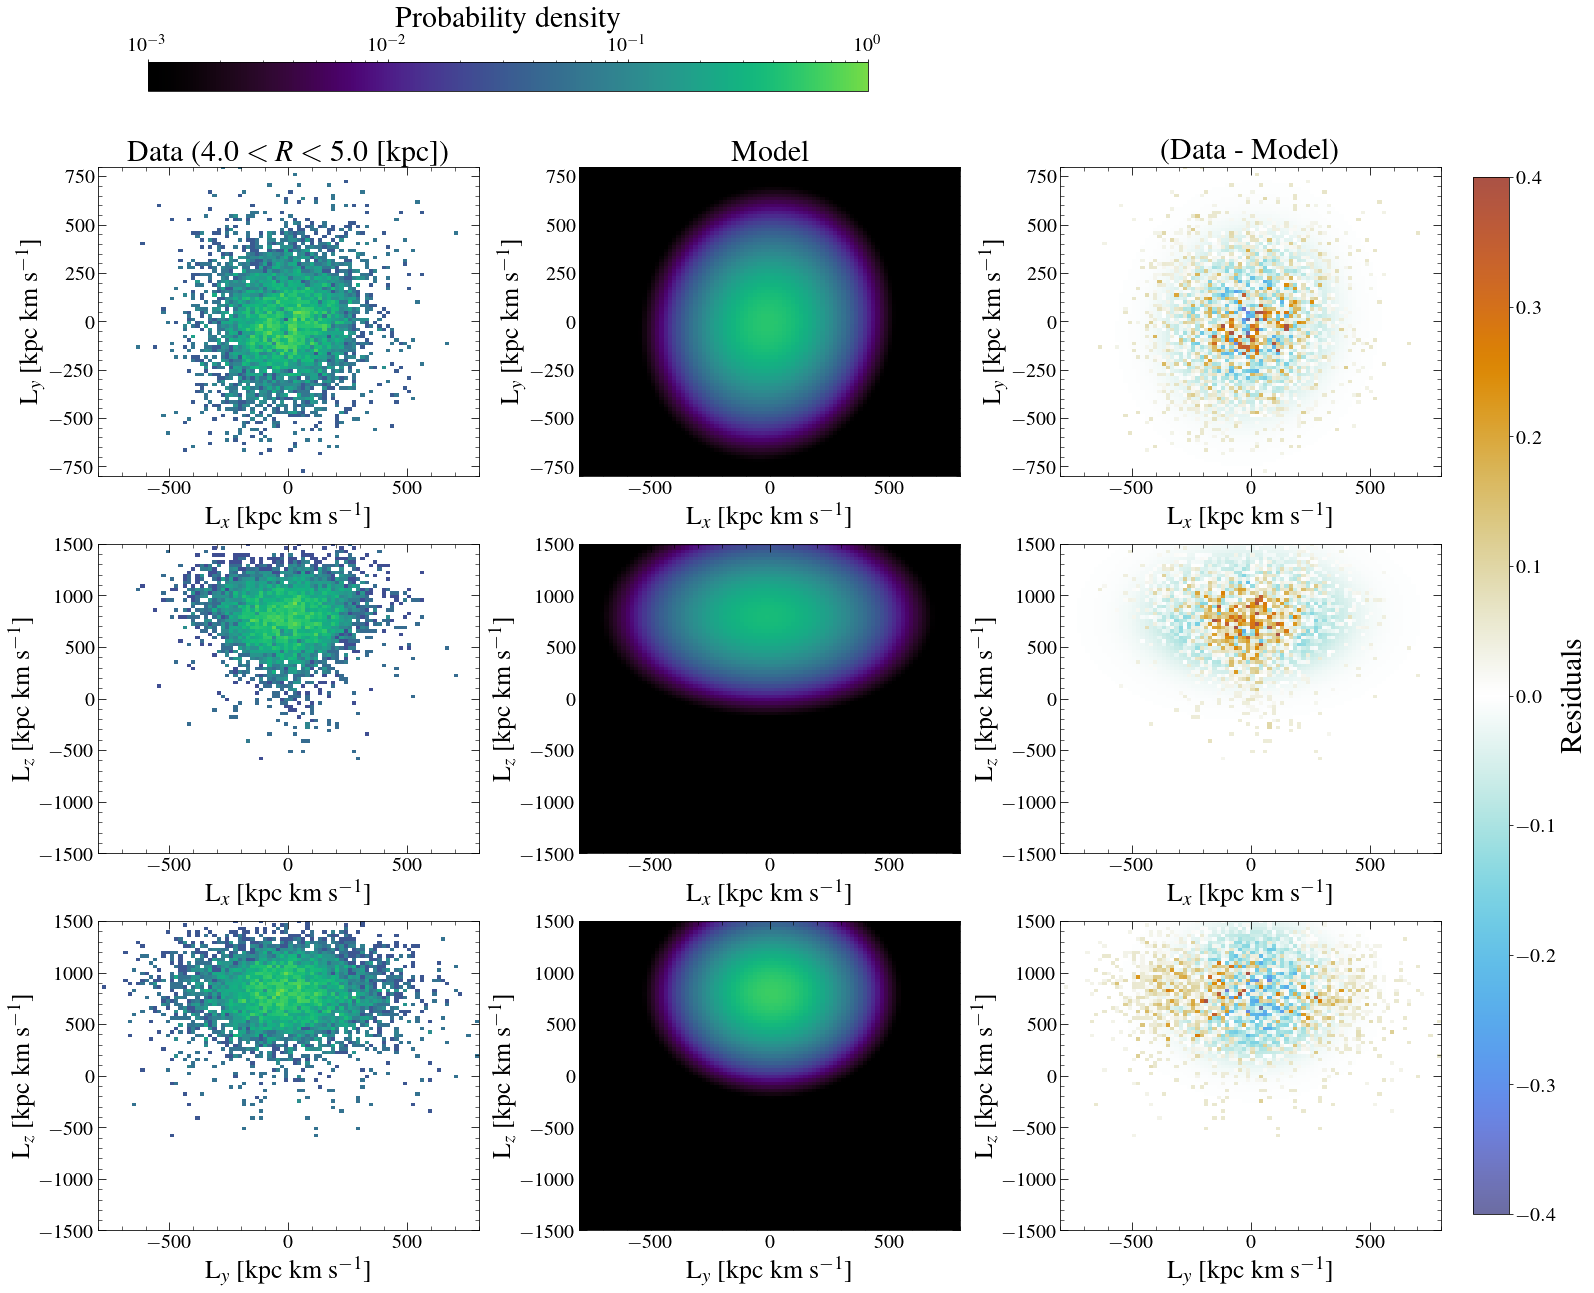

In [399]:
plot_2d_model_data_comp(4.,5.,1,err_lx, err_ly, err_lz, '2d-datamodelcomp-4-5kpc')

NOTE: I have no idea why, but in the outer bins, I have to rotate the model plot by 180 degrees. I think it has to do with the fact that the disc is negative in Lz.
